## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [14]:
!pip install -r requirements.txt

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import random

In [6]:
%matplotlib inline

### load the dataset

In [7]:
### set your image dir here
IMAGE_DIR = "/Users/manideepattanti/Acads/SEM1/ML/hw3/upload_folder/all/"

In [8]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [9]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/Users/manideepattanti/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [10]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

/Users/manideepattanti/Acads/SEM1/ML/hw3/upload_folder/all/train/1.png


/Users/manideepattanti/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/manideepattanti/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


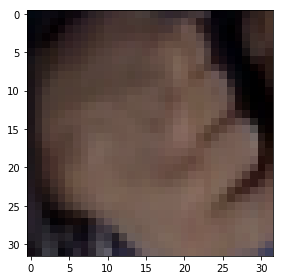

In [11]:
display(IMAGE_DIR+"train/1.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [14]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    
    def log_likelihood(self, X, y, theta):
        sigmoid_val = self.sigmoid(np.dot(X, theta))
        val1 = np.dot(y, np.log(sigmoid_val))
        val2 = np.dot((1 - y), np.log(1 - sigmoid_val))
        ll = val1 + val2
        return (-1/len(y)) * ll

    def log_likelihood_differential(self, X, y, theta):
        lld = np.dot(np.transpose(X), (self.sigmoid(np.dot(X, theta)) - y))
        return lld / len(y)
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        
        n, d = X.shape
        self.__dimension = d
        
        if self.__init:
            self.__init_param()
        
        ### write your code here ### 
        array_1 = np.transpose(np.asarray([[1]*n], dtype=float))
        X_bar = np.concatenate((X, array_1), axis=1)
        y_orig = y
        theta = np.append(self.__wt, self.__bias)
        num_epoch = 0
        train_accuracy_array = []
        val_accuracy_array = []
        L_theta_old = 1000
        L_theta_train_array = [1000]
        L_theta_val_array = [1000]
        for i in range(1, self.__max_epoch + 1):
            eta = self.__eta0/(self.__eta1 + i)
            merged_list = list(zip(X_bar, y))
            random.shuffle(merged_list)
            X_bar, y = zip(*merged_list)
            X_bar = np.asarray(X_bar)
            y = np.asarray(y)
            num_batches = int(n / self.__m) + 1
            for i in range(num_batches):
                X_batch = X_bar[i * self.__m:min((i+1) * self.__m, n)]
                y_batch = y[i * self.__m:min((i+1) * self.__m, n)]
                theta = theta - (eta * self.log_likelihood_differential(X_batch, y_batch, theta))
            self.__wt = theta[:-1]
            self.__bias = theta[-1]
            y_train_pred = self.predict(X)
            train_accuracy_array.append((y_train_pred == y_orig).mean())
            if y_val.all() != None:
                array_val_1 = np.transpose(np.asarray([[1]*X_val.shape[0]], dtype=float))
                X_val_bar = np.concatenate((X_val, array_val_1), axis=1)
                y_val_pred = self.predict(X_val)
                val_accuracy_array.append((y_val_pred == y_val).mean())
                L_theta_val = self.log_likelihood(X_val_bar, y_val, theta)
                L_theta_val_array.append(L_theta_val)
            L_theta_new = self.log_likelihood(X_bar, y, theta)
            L_theta_train_array.append(L_theta_new)
            num_epoch = num_epoch + 1
            if L_theta_new > (1 - self.__delta) * L_theta_old:
                break
            L_theta_old = L_theta_new
        self.__wt = theta[:-1]
        self.__bias = theta[-1]
        ############################
        return num_epoch, L_theta_train_array, L_theta_val_array, train_accuracy_array, val_accuracy_array
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        theta = np.append(self.__wt, self.__bias)
        array_1 = np.transpose(np.asarray([[1]*X.shape[0]], dtype=float))
        X_bar = np.concatenate((X, array_1), axis=1)
        val = np.dot(np.transpose(theta), np.transpose(X_bar))
        return self.sigmoid(val)
    
    def predict(self, X):
        """
        Classify the sample
        """
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3

### 1. Baseline Model

In [345]:
LR = LogisticRegression()
num_epochs, L_theta_array_train, L_theta_array_val, accuracy_array_train, accuracy_array_val = LR.fit(X_train,y_train, X_val, y_val)
print(num_epochs)

373


(a) Number of epochs till termination = 373

L(theta) after optimization 0.5196598086704581


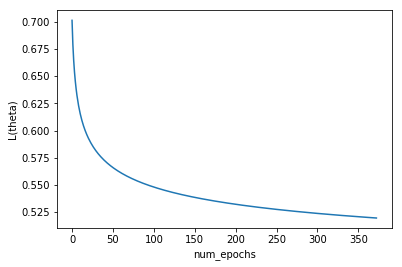

In [346]:
# (b) Plot L(theta) vs num_epochs
plt.plot(L_theta_array_train[1:])
plt.xlabel('num_epochs')
plt.ylabel('L(theta)')
print("L(theta) after optimization", L_theta_array_train[-1])

(c) Final value of L($\theta$) after optimization = 0.5196598086704581

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [15]:
# Experimentation code goes here
e0 = 0.1
e1 = 1 
for i in range(1, 16):
    LR = LogisticRegression(eta0=e0, eta1=e1)
    num_epoch, L_theta_array_train, L_theta_array_val, accuracy_array_train, accuracy_array_val = LR.fit(X_train, y_train, X_val, y_val)
    print(e0, e1, num_epoch, L_theta_array_train[-1], L_theta_array_val[-1], accuracy_array_train[-1], accuracy_array_val[-1])
    e0 = e0 * 2
# Keeping the value of eta1 constant and changing the value of eta0

0.1 1 332 0.5057255948766882 0.5073352649349249 0.8194614443084456 0.8190161527165932
0.2 1 382 0.45182498406637794 0.44856965492134193 0.8317013463892289 0.8388399412628488
0.4 1 385 0.3915452719934143 0.3846349756874715 0.8550795593635251 0.8604992657856094
0.8 1 319 0.3418967934477724 0.34124807556354153 0.87062423500612 0.8718795888399412
1.6 1 263 0.3075027739107094 0.3057974778976453 0.8833537331701347 0.8854625550660793
3.2 1 35 0.3003521244981595 0.3008726702585439 0.8839657282741739 0.8803230543318649
6.4 1 14 0.28773104119135495 0.2887811222485853 0.8905752753977968 0.8865638766519823
12.8 1 2 0.3327035742026436 0.33791383634060096 0.8673194614443085 0.8593979441997063
25.6 1 2 0.3520980987837249 0.36289289001953384 0.8460220318237454 0.8373715124816447
51.2 1 2 0.37702100595290866 0.3646125239537728 0.8467564259485925 0.855359765051395
102.4 1 4 0.3492812066854029 0.38735495680850734 0.877233782129743 0.8678414096916299


/Users/manideepattanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


204.8 1 5 0.6717978057731866 0.6639936375506705 0.8455324357405141 0.8472834067547724
409.6 1 12 0.5361882942207498 0.6309478202295474 0.8654834761321909 0.8586637298091042
819.2 1 27 0.46436867945690685 0.5709104786035497 0.8753977968176254 0.8671071953010279
1638.4 1 52 0.3682324373352419 0.45713369435488327 0.8962056303549572 0.8781204111600588


(a) Best value for, $\eta_0$ = \6.4, $\eta_1$ = \1

Number of epochs for training = 14

Final value of L($\theta$) = 0.28773104119135495

14


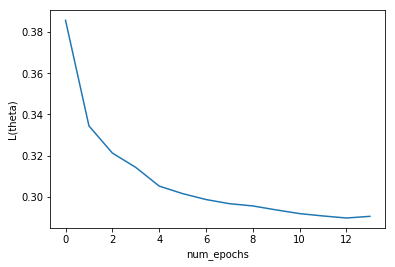

In [18]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs
LR = LogisticRegression(eta0=6.4, eta1=1)
num_epochs, L_theta_array_train, L_theta_array_val, accuracy_array_train, accuracy_array_val = LR.fit(X_train,y_train, X_val, y_val)
print(num_epochs)
plt.plot(L_theta_array_train[1:])
plt.xlabel('num_epochs')
plt.ylabel('L(theta)')
plt.show()

### 3. Evaluating on validation set

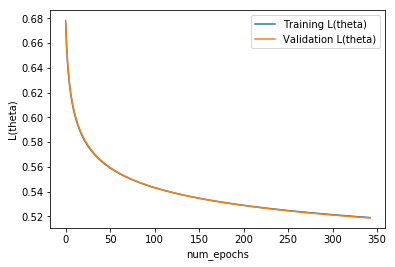

In [347]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure
LR = LogisticRegression()
num_epochs, L_theta_array_train, L_theta_array_val, accuracy_array_train, accuracy_array_val = LR.fit(X_train,y_train, X_val, y_val)
plt.plot(L_theta_array_train[1:], label="Training L(theta)")
plt.plot(L_theta_array_val[1:], label="Validation L(theta)")
plt.xlabel('num_epochs')
plt.ylabel('L(theta)')
plt.legend()

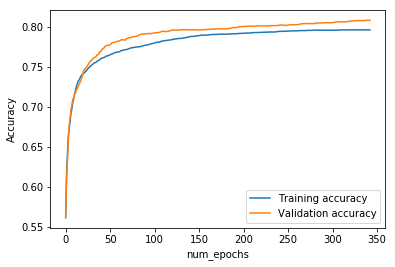

In [348]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure
plt.plot(accuracy_array_train, label="Training accuracy")
plt.plot(accuracy_array_val, label="Validation accuracy")
plt.xlabel('num_epochs')
plt.ylabel('Accuracy')
plt.legend()

### 4. ROC and Precision-Recall curves

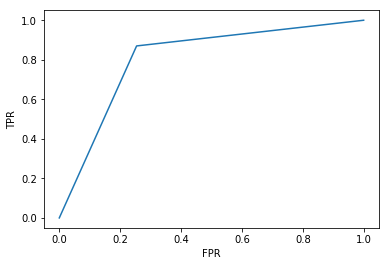

0.8080029368575624


In [353]:
#(a) Plot ROC curve on validation data
y_pred = LR.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(roc_auc_score(y_val, y_pred))

Area under curve = 0.8080029368575624

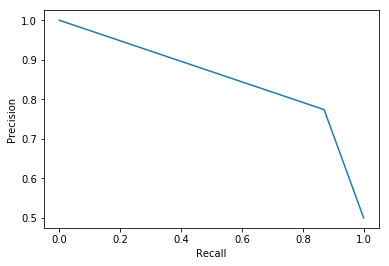

0.7383954801934758


In [354]:
#(a) Plot Precision-Recall curve on validation data
precision, recall, _ = precision_recall_curve(y_val, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
print(average_precision_score(y_val, y_pred))

In [ ]:
Average Precision = 0.7383954801934758

## Question 2.4

### 1. Submission

In [287]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission4.csv",index=0)       

#### Generate the submission.csv

In [351]:
# code goes here
LR_pred = LogisticRegression(eta0=101, eta1=1, m=8, max_epoch=1000)
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
LR_pred.fit(X, y, X_val, y_val)
y_test = LR_pred.predict(X_test)
# print((y_pred == y_val).mean())
submission(y_test)

Best obtained accuracy on Public Leader-board = 88.704%